## The collapse poset of a 2-dimensional simplicial set

The point of this notebook is to define a function which takes as input a 2-dimensional simplicial set $X$, and provides as output a poset whose vertices are simplicial sets obtained as collapses of $X$. The important point here is that, given a list of 2-simplices $\sigma_i$ of $X$, and a list of indices $j_i\in \{0,1\}$, it does not matter what order we collapse the simplices $\sigma_i$ in, so long as we always collapse $\sigma_i$ along the $j_i$-th face map. This means that the collapse poset will always be a subset of the $k$-cube $\mathcal{P}(X_2^{\operatorname{nd}}\times \{0,1\})$. Our first step will be to generate this cube from $X$. There are two ways of doing so: as a set, or as a lattice. 

In [1]:
from sage.topology.simplicial_set import AbstractSimplex, SimplicialSets

In [2]:
def collset(X):
    # Extract non-degenerate 2-simplices
    simps = X.n_cells(2)

    # Generate pairs of (simplex, i) where i is in {0, 1}
    X_collapses = Set(cartesian_product([simps, [0, 1]]))

    # Return a list of all subsets of these pairs
    return list(X_collapses.subsets())
    
def colllattice(X):
    # Extract non-degenerate 2-simplices
    simps = X.n_cells(2)

    # Generate pairs of (simplex, i) where i is in {0, 1}
    X_collapses = Set(cartesian_product([simps, [0, 1]]))

    # Return the lattice of all subsets of these pairs
    return X_collapses.subsets_lattice()

Example: the torus

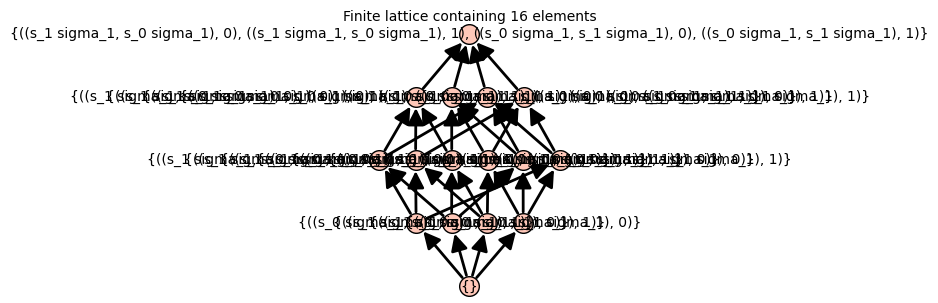

In [3]:
T = simplicial_sets.Torus()
Tlat = colllattice(T)
Tlat

Our next objective is to eliminate duplicates, by which I mean, restrict to those $\{(\sigma_1,j_1),\ldots,(\sigma_k,j_k)\}$ such that $\sigma_\ell= \sigma_r$ for $\ell\neq r$. 

In [4]:
def isduplicate(S):
    # Track seen simplices
    seen = set()

    # Check each simplex part for duplicates
    for simplicial_part in S:
        simplex = simplicial_part[0]
        if simplex in seen:
            return True
        seen.add(simplex)

    return False
    
def removeduplicates(L):
    return [item for item in L if not isduplicate(item)]

Example: the torus.

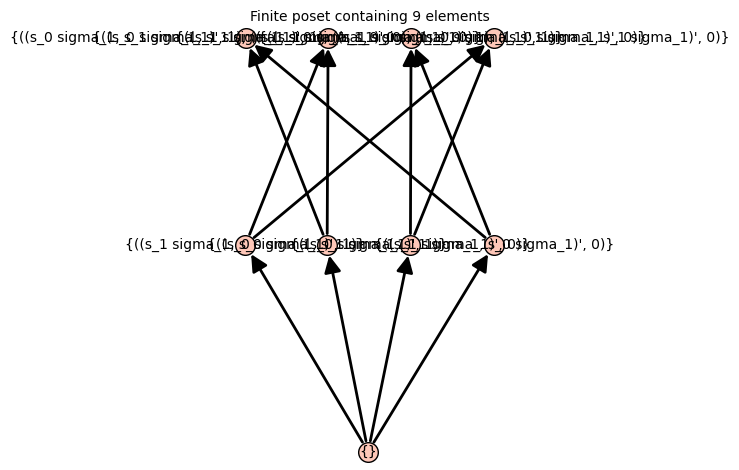

In [5]:
TND = removeduplicates(list(Tlat))
Tlat.subposet(TND)

We then need a function which implements a sequence of collapses specified by pairs $(\sigma,j)$ consisting of a simplex of $X$ and an index in $\{0,1\}$. We first define a function which implements a single collapse map. 

In [6]:
def collapse_simplex(X, sigma, i):
    # Create instances of the 2-simplex and the 1-simplex
    simp2 = simplicial_sets.Simplex(2)
    simp1 = simplicial_sets.Simplex(1)

    # Define the Homset from the 2-simplex to X
    H = Hom(simp2, X)
    # Choose the map which picks out sigma
    f1 = H({simp2.n_cells(2)[0]: sigma})

    # Define the Homset from delta2 to delta1
    G = Hom(simp2, simp1)
    # Specify the unique non-degenerate 1-simplex
    u01 = simp1.n_cells(1)[0]
    # Define the degeneracy map s_i
    s = G({simp2.n_cells(2)[0]: u01.apply_degeneracies(i)})

    # Compute the pushout against the degeneracy map s_i
    Y = simp2.pushout(f1, s)

    # Return the resulting simplicial set after the collapse
    return Y

We then iterate through these collapses to obtain the corresponding simplicial set. 

In [7]:
def collapseSimps(X, collapses):
    # Convert the enumerated set to a list for processing
    collapses = list(collapses)
    Y = X

    # Process each collapse in the list
    for i in range(len(collapses)):
        # Current collapse operation
        sigma, ind = collapses[i]

        # Perform the collapse on the current simplicial set Y
        Y = collapse_simplex(Y, sigma, ind)

        # If there are more collapses to process, update their simplices
        if i < len(collapses) - 1:
            # Update the structure map and apply it to the future collapses
            f = Y.structure_map(0)
            collapses[i+1:] = [(f(c[0]), c[1]) for c in collapses[i+1:]]

    # Return the modified simplicial set
    return Y


Example: we chose on element of the collapse poset of the torus, and obtain the corresponding simplicial set by collapse.

In [8]:
TND[6]

{((s_0 sigma_1, s_1 sigma_1), 0)}

In [9]:
Ttest = TND[6]
C3 = collapseSimps(T, Ttest)
C3.nondegenerate_simplices()

[(0,), (0, 2), (s_1 sigma_1, s_0 sigma_1)]

We next remove the 0-dimensional and 1-dimensional vertices. 

In [10]:
def removeLDim(X, collapses):
    return [collapse for collapse in collapses if collapseSimps(X, collapse).dimension() == 2]

In [11]:
TND

[{},
 {((s_0 sigma_1, s_1 sigma_1), 1)},
 {((s_1 sigma_1, s_0 sigma_1), 0)},
 {((s_1 sigma_1, s_0 sigma_1), 0), ((s_0 sigma_1, s_1 sigma_1), 1)},
 {((s_1 sigma_1, s_0 sigma_1), 1)},
 {((s_1 sigma_1, s_0 sigma_1), 1), ((s_0 sigma_1, s_1 sigma_1), 1)},
 {((s_0 sigma_1, s_1 sigma_1), 0)},
 {((s_1 sigma_1, s_0 sigma_1), 1), ((s_0 sigma_1, s_1 sigma_1), 0)},
 {((s_1 sigma_1, s_0 sigma_1), 0), ((s_0 sigma_1, s_1 sigma_1), 0)}]

In [12]:
TGD = removeLDim(T,TND)
TGD

[{},
 {((s_0 sigma_1, s_1 sigma_1), 1)},
 {((s_1 sigma_1, s_0 sigma_1), 0)},
 {((s_1 sigma_1, s_0 sigma_1), 1)},
 {((s_0 sigma_1, s_1 sigma_1), 0)}]

Finally, we develop code to test whether a given simplicial set is a wedge of the basic contextual pieces. 


In [13]:
### this function tests if a given simplex of a simplicial set is a basic contextual piece.
def is_basic_cont(X, sigma):
     # Check if at least two faces are equal and all are nondegenerate
    faces = X.faces(sigma)
    nondegenerate = all(face.is_nondegenerate() for face in faces)

    if nondegenerate:
        if faces[0] == faces[1] or faces[0] == faces[2] or faces[1] == faces[2]:
            return True

    return False

## this function tests if all 2-simplices of a simplicial set X are basic contextual pieces.
def all_basic_cont(X):
    # Check if all 2-simplices in X are basic contextual pieces
    return all(is_basic_cont(X, k) for k in X.n_cells(2))

In [14]:
all_basic_cont(T)

False

In [15]:
TGD[3]

{((s_1 sigma_1, s_0 sigma_1), 1)}

In [16]:
all_basic_cont(collapseSimps(T,TGD[4]))

False

We now can test the individual vertices of a scenario to see if they are basic contextual. We will apply this to the Mermin square (punctured torus) TODO: Insert Image

<img src="attachment:01be01cc-845a-43e6-a256-5b919a85da41.png" alt="drawing" width="200"/>


In [17]:
from sage.topology.simplicial_set import AbstractSimplex, SimplicialSet
sigma = AbstractSimplex(2,name='sigma')
gamma = AbstractSimplex(2,name='gamma')
eta = AbstractSimplex(2,name='eta')
tau = AbstractSimplex(2,name='tau')
mu = AbstractSimplex(2,name='mu')

f = AbstractSimplex(1,name='f')
g = AbstractSimplex(1,name='g')
h = AbstractSimplex(1,name='h')
u = AbstractSimplex(1,name='u')
v = AbstractSimplex(1,name='v')
w = AbstractSimplex(1,name='w')
a = AbstractSimplex(1,name='a')
b = AbstractSimplex(1,name='b')
c = AbstractSimplex(1,name='c')

x = AbstractSimplex(0,name='x')
y = AbstractSimplex(0,name='y')
z = AbstractSimplex(0,name='z')


punctured_mermin = SimplicialSet({sigma:(f,h,u),
                      gamma:(g,b,u),
                      eta:(c,v,b),
                      tau:(w,c,f),
                      mu:(w,a,g),
                      f:(x,x),
                      h:(x,y),
                      u:(x,y),
                      g:(x,x),
                      a:(z,x),
                      v:(z,y),
                      c:(z,x),
                      b:(x,y),
                      w:(z,x)})

double_punctured_mermin = SimplicialSet({sigma:(f,h,u),
                      gamma:(g,b,u),
                      tau:(w,c,f),
                      mu:(w,a,g),
                      f:(x,x),
                      h:(x,y),
                      u:(x,y),
                      g:(x,x),
                      a:(z,x),
                      c:(z,x),
                      b:(x,y),
                      w:(z,x)})

example_1 = SimplicialSet(data={sigma: (f,h,u),
                      tau: (g,h,u),
                      f:(z,y),
                      g:(z,y),
                      h:(z,x),
                      u:(y,x)})

example_2 = SimplicialSet(data={sigma: (f,b,u),
                      tau: (g,h,u),
                      eta: (b,h,v),
                      f:(z,y),
                      u:(y,x),
                      g:(z,y),
                      h:(z,x),
                      v:(x,x),
                      b:(z,x)})

In [18]:
triangle = SimplicialSet(data={sigma:(f,g,h), f:(x,y), g:(x,z), h:(y,z)})
triangle.face(sigma, 0)

f

As a check to ensure I've entered the Mermin square correctly, I compute the homology (which should be that of the wedge of two circles). 

In [19]:
punctured_mermin.homology()

{0: 0, 1: Z x Z, 2: 0}

In [20]:
double_punctured_mermin.homology()

{0: 0, 1: Z x Z, 2: 0}

In [21]:
def find_maximal_elements(X):
    # Initialize a list to store maximal elements
    maximal_elements = []
    
    for element in X:
        # Assume the element is maximal until proven otherwise
        is_maximal = True

        # Compare with other elements and if it is a subset of another element then it is not maximal.
        for other_element in X:
            if element != other_element and element.issubset(other_element):
                is_maximal = False
                break
                
        # If the element is maximal, add it to the list
        if is_maximal:
            maximal_elements.append(element)

    return maximal_elements

In [22]:
def get_collapse_list(X):
    # Define the coarse lattice of possible collapses
    collapse_lattice = colllattice(X)
    
    # Convert the poset into a list and remove duplicates because these collapses cannot be realized 
    # since it collapses the same simplex twice.
    collapse_list = removeduplicates(list(collapse_lattice))
    
    # Remove elements which result in a simplicial set with dimension less than 2.
    collapse_list = removeLDim(X, collapse_list)
    
    # Find maximal elements, which represent minimal non-trivial collapses
    # (in the sense that everything except one two-simplex has been collapsed)
    collapse_list = find_maximal_elements(collapse_list)

    return collapse_list

In [23]:
punctured_mermin_collapse_list = get_collapse_list(punctured_mermin)

In [24]:
example_collapse = punctured_mermin_collapse_list[0]
print(example_collapse)

{(mu, 1), (sigma, 1), (tau, 1), (eta, 0)}


In [25]:
collapseSimps(punctured_mermin, example_collapse)

Pushout of maps:
  Simplicial set morphism:
    From: 2-simplex
    To:   Pushout of maps:
    Simplicial set morphism:
      From: 2-simplex
      To:   Pushout of maps:
      Simplicial set morphism:
        From: 2-simplex
        To:   Pushout of maps:
        Simplicial set morphism:
          From: 2-simplex
          To:   Simplicial set with 17 non-degenerate simplices
          Defn: [(0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)] --> [x, x, z, g, a, w, mu]
        Simplicial set morphism:
          From: 2-simplex
          To:   1-simplex
          Defn: [(0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)] --> [(0,), (1,), (1,), (0, 1), (0, 1), s_0 (1,), s_1 (0, 1)]
        Defn: [(0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)] --> [y, (0,), (0,), u, h, f, sigma]
      Simplicial set morphism:
        From: 2-simplex
        To:   1-simplex
        Defn: [(0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)] --> [(0,), (1,), (1,), (0, 1), (0, 1), s_0 (1,), s_1 (0,

In [26]:
def has_contextual_collapse(X):
    """
    Check if the simplicial set X has a contextual collapse.
    A contextual collapse is one where all 2-simplices in the resulting 
    simplicial set are basic contextual pieces.
    """
    
    # Generate a list of potential collapses for X
    collapse_list = get_collapse_list(X)

    # Check each potential collapse
    for collapse in collapse_list:
        # Apply the collapse and check if all 2-simplices are basic contextual pieces
        if all_basic_cont(collapseSimps(X, collapse)):
            return True

    # If no suitable collapse is found, return False
    return False

In [27]:
has_contextual_collapse(punctured_mermin)

False

In [28]:
has_contextual_collapse(double_punctured_mermin)

False

In [29]:
has_contextual_collapse(example_1)

True

In [30]:
has_contextual_collapse(example_2)

True

In [31]:
from sage.topology.simplicial_set import AbstractSimplex, SimplicialSet
from itertools import permutations

class DoublyPuncturedMermin:
    def __init__(self, total_order):
        # We will use this total order as 
        # a has the value total_order[0], b has the value total_order[1], etc.
        self._total_order = total_order
        
        # Apply the given restrictions
        if not self.check_restrictions(total_order):
            raise ValueError("The given total order does not meet the restrictions\n \
                             Remember that the orientation rules are: \n \
                             If a < b, then we must have d < c \
                             If a > b, then we must have d > c \
                             If a < d, then we must have b < c \
                             If a > d, then we must have b > c")

        self._simp_set = self._get_simplical_set()

    @property
    def total_order(self):
        return self._total_order
    
    @property
    def simp_set(self):
        return self._simp_set
    
    @classmethod
    def check_restrictions(cls, order):
        if len(order) != 6:
            raise ValueError("The total order must have three elements")
        
        if len(set(order)) != 6:
            raise ValueError("The total order must have six unique elements")
        
        # Extract the relevant elements
        a, b, c, d = order[0:4]
        
        # We want these restriction to hold because we want to ensure that
        # ab & dc and ad & bc edges are in same direction
        # Hence we won't have twist when we identify these edges
        if a < b and d > c:
            return False
        if a > b and d < c:
            return False
        if a < d and b > c:
            return False
        if a > d and b < c:
            return False
        
        # If all checks pass, the permutation meets the restrictions
        return True

    def _identify_edges(self, simp_set, edge_1, edge_2):
        union = simplicial_sets.Simplex(1).disjoint_union(simplicial_sets.Simplex(1))
        
        simp1 = simplicial_sets.Simplex(1)
        
        H = Hom(union, simp_set)
        f1 = H({union.n_cells(1)[0]: edge_1, union.n_cells(1)[1]: edge_2})

        G = Hom(union, simp1)
        u01 = simp1.n_cells(1)[0]
        s = G({union.n_cells(1)[0]: u01 , union.n_cells(1)[1]: u01})

        Y = union.pushout(f1, s)

        return Y

            
    def _get_face_order(self, simplicial_complexes, vertices):
        # order vertices
        ordered_vertices = sorted(vertices)

        # We remove the i-th vertex from the ordered vertices and 
        # add the corresponding simplicial complex to the tuple as the i-th face
        return tuple(simplicial_complexes[tuple(ordered_vertices[:i] + ordered_vertices[i+1:])] for i in range(len(ordered_vertices)))

    def _get_simplical_set(self) -> SimplicialSet:
        # Define the vertices of the 2-simplex
        # Caution! For example a=4 does not mean that a is the 4th element in the total order
        # It means that a is the element with the value 4 in the total order
        a, b, c, d, e, f = self.total_order

        # Define the 0-simplices
        vert_a = AbstractSimplex(0, name="a", latex_name="a")
        vert_b = AbstractSimplex(0, name="b", latex_name="b")
        vert_c = AbstractSimplex(0, name="c", latex_name="c")
        vert_d = AbstractSimplex(0, name="d", latex_name="d")
        vert_e = AbstractSimplex(0, name="e", latex_name="e")
        vert_f = AbstractSimplex(0, name="f", latex_name="f")

        # Initializes simplicial complexes
        # We use tuples as keys even for 1-simplices in order to write _get_face_order method easily
        simplicial_complexes = {(a,): vert_a, (b,): vert_b, (c,): vert_c, (d,): vert_d, (e,): vert_e, (f,): vert_f}

        # This data dictionary will be used to create the simplicial set
        data={}

        # Define the 1-simplices
        edge_ab = AbstractSimplex(1, name="ab", latex_name="ab")
        data[edge_ab] = self._get_face_order(simplicial_complexes, (a, b))
        simplicial_complexes[tuple(sorted([a, b]))] = edge_ab

        edge_ad = AbstractSimplex(1, name="ad", latex_name="ad")
        data[edge_ad] = self._get_face_order(simplicial_complexes, (a, d))
        simplicial_complexes[tuple(sorted([a, d]))] = edge_ad

        edge_ae = AbstractSimplex(1, name="ae", latex_name="ae")
        data[edge_ae] = self._get_face_order(simplicial_complexes, (a, e))
        simplicial_complexes[tuple(sorted([a, e]))] = edge_ae
        
        edge_af = AbstractSimplex(1, name="af", latex_name="af")
        data[edge_af] = self._get_face_order(simplicial_complexes, (a, f))
        simplicial_complexes[tuple(sorted([a, f]))] = edge_af
    
        edge_bc = AbstractSimplex(1, name="bc", latex_name="bc")
        data[edge_bc] = self._get_face_order(simplicial_complexes, (b, c))
        simplicial_complexes[tuple(sorted([b, c]))] = edge_bc

        edge_bf = AbstractSimplex(1, name="bf", latex_name="bf")
        data[edge_bf] = self._get_face_order(simplicial_complexes, (b, f))
        simplicial_complexes[tuple(sorted([b, f]))] = edge_bf

        edge_cd = AbstractSimplex(1, name="cd", latex_name="cd")
        data[edge_cd] = self._get_face_order(simplicial_complexes, (c, d))
        simplicial_complexes[tuple(sorted([c, d]))] = edge_cd

        edge_ce = AbstractSimplex(1, name="ce", latex_name="ce")
        data[edge_ce] = self._get_face_order(simplicial_complexes, (c, e))
        simplicial_complexes[tuple(sorted([c, e]))] = edge_ce

        edge_cf = AbstractSimplex(1, name="cf", latex_name="cf")
        data[edge_cf] = self._get_face_order(simplicial_complexes, (c, f))
        simplicial_complexes[tuple(sorted([c, f]))] = edge_cf

        edge_de = AbstractSimplex(1, name="de", latex_name="de")
        data[edge_de] = self._get_face_order(simplicial_complexes, (d, e))
        simplicial_complexes[tuple(sorted([d, e]))] = edge_de

        # Define the 2-simplex
        triangle_ade = AbstractSimplex(2, name="ade", latex_name="ade")
        data[triangle_ade] = self._get_face_order(simplicial_complexes, (a, d, e))
        simplicial_complexes[tuple(sorted([a, d, e]))] = triangle_ade
        
        triangle_abf = AbstractSimplex(2, name="abf", latex_name="abf")
        data[triangle_abf] = self._get_face_order(simplicial_complexes, (a, b, f))
        simplicial_complexes[tuple(sorted([a, b, f]))] = triangle_abf

        triangle_bcf = AbstractSimplex(2, name="bcf", latex_name="bcf")
        data[triangle_bcf] = self._get_face_order(simplicial_complexes, (b, c, f))
        simplicial_complexes[tuple(sorted([b, c, f]))] = triangle_bcf

        triangle_ced = AbstractSimplex(2, name="ced", latex_name="ced")
        data[triangle_ced] = self._get_face_order(simplicial_complexes, (c, e, d))
        simplicial_complexes[tuple(sorted([c, e, d]))] = triangle_ced

        # Define the simplicial set
        S = SimplicialSet(data=data)

        # We identify the top and bottom edges of the Doubly Punctured Mermin's simplicial set
        S = self._identify_edges(S, edge_ab, edge_cd)

        # We need to update the structure map because we have identified the edges
        f = S.structure_map(0)
    
        # We identify the left and right edges of the Doubly Punctured Mermin's simplicial set
        # We need to update these edges according to the new structure map
        S = self._identify_edges(S, f(edge_ad), f(edge_bc))

        return S

    @classmethod
    def collapse_with_each_orientation(cls):
        items = [0, 1, 2, 3, 4, 5]
    
        # Creates all possible permutations of the items that will give same direction in top & bottom and left & right edges
        valid_perms = [perm for perm in permutations(items) if DoublyPuncturedMermin.check_restrictions(perm)]
        total_perms = len(valid_perms)
    
        # We store the permutations that result in a contextual collapse
        contextual_dpms = []
        for i, perm in enumerate(valid_perms, start=1):
            # Create a DoublyPuncturedMermin instance with the current permutation
            dpm = DoublyPuncturedMermin(perm)
            simp_set = dpm.simp_set

            # Check if the current permutation results in a contextual collapse
            if has_contextual_collapse(simp_set):
                contextual_dpms.append(perm)
            
            # Inform the user about the progress
            progress = int((i / total_perms) * 10) 
            progress_string = '+' * progress + '.' * (10 - progress)  # Create a string with '+' for completed progress and '.' for remaining progress
            print(f'{progress_string} {i}/{total_perms} completed, {len(contextual_dpms)} contextual Doubly Punctured Mermin found', end='\r')

        return contextual_dpms

In [32]:
pm = DoublyPuncturedMermin([0,1,3,2,4,5])
pm.simp_set.homology()

{0: 0, 1: Z x Z, 2: 0}

In [33]:
DoublyPuncturedMermin.collapse_with_each_orientation()

[(1, 0, 2, 4, 3, 5),
 (1, 0, 2, 5, 3, 4),
 (1, 0, 2, 5, 4, 3),
 (1, 0, 3, 4, 2, 5),
 (1, 0, 3, 5, 2, 4),
 (1, 0, 3, 5, 4, 2),
 (1, 0, 4, 5, 2, 3),
 (1, 0, 4, 5, 3, 2),
 (1, 4, 2, 0, 5, 3),
 (1, 4, 3, 0, 5, 2),
 (1, 5, 2, 0, 3, 4),
 (1, 5, 2, 0, 4, 3),
 (1, 5, 3, 0, 2, 4),
 (1, 5, 3, 0, 4, 2),
 (1, 5, 4, 0, 2, 3),
 (1, 5, 4, 0, 3, 2),
 (2, 0, 1, 4, 3, 5),
 (2, 0, 1, 5, 3, 4),
 (2, 0, 1, 5, 4, 3),
 (2, 0, 3, 4, 1, 5),
 (2, 0, 3, 5, 1, 4),
 (2, 0, 3, 5, 4, 1),
 (2, 0, 4, 5, 1, 3),
 (2, 0, 4, 5, 3, 1),
 (2, 1, 3, 4, 0, 5),
 (2, 1, 3, 5, 0, 4),
 (2, 1, 4, 5, 0, 3),
 (2, 4, 1, 0, 5, 3),
 (2, 4, 3, 0, 5, 1),
 (2, 4, 3, 1, 5, 0),
 (2, 5, 1, 0, 3, 4),
 (2, 5, 1, 0, 4, 3),
 (2, 5, 3, 0, 1, 4),
 (2, 5, 3, 0, 4, 1),
 (2, 5, 3, 1, 4, 0),
 (2, 5, 4, 0, 1, 3),
 (2, 5, 4, 0, 3, 1),
 (2, 5, 4, 1, 3, 0),
 (3, 0, 1, 4, 2, 5),
 (3, 0, 1, 5, 2, 4),
 (3, 0, 1, 5, 4, 2),
 (3, 0, 2, 4, 1, 5),
 (3, 0, 2, 5, 1, 4),
 (3, 0, 2, 5, 4, 1),
 (3, 0, 4, 5, 1, 2),
 (3, 0, 4, 5, 2, 1),
 (3, 1, 2, 4, 0, 5),
 (3, 1, 2, 5,

In [34]:
class PuncturedMermin:
    def __init__(self, total_order):
        # We will use this total order as 
        # a has the value total_order[0], b has the value total_order[1], etc.
        self._total_order = total_order
        
        # Apply the given restrictions
        if not self.check_restrictions(total_order):
            raise ValueError("The given total order does not meet the restrictions\n \
                             Remember that the orientation rules are: \n \
                             If a < b, then we must have d < c \
                             If a > b, then we must have d > c \
                             If a < d, then we must have b < c \
                             If a > d, then we must have b > c")

        self._simp_set = self._get_simplical_set()

    @property
    def total_order(self):
        return self._total_order
    
    @property
    def simp_set(self):
        return self._simp_set

        
    @classmethod
    def check_restrictions(cls, order):
        if len(order) != 6:
            raise ValueError("The total order must have three elements")
        
        if len(set(order)) != 6:
            raise ValueError("The total order must have six unique elements")
        
        # Extract the relevant elements based on the problem statement
        a, b, c, d = order[0:4]
        
        # We want these restriction to hold because we want to ensure that
        # ab & dc and ad & bc edges are in same direction
        # Hence we won't have twist when we identify these edges
        if a < b and d > c:
            return False
        if a > b and d < c:
            return False
        if a < d and b > c:
            return False
        if a > d and b < c:
            return False
        
        # If all checks pass, the permutation meets the restrictions
        return True

    def _identify_edges(self, simp_set, edge_1, edge_2):
    
        union = simplicial_sets.Simplex(1).disjoint_union(simplicial_sets.Simplex(1))
        
        simp1 = simplicial_sets.Simplex(1)
        
        H = Hom(union, simp_set)
        f1 = H({union.n_cells(1)[0]: edge_1, union.n_cells(1)[1]: edge_2})

        G = Hom(union, simp1)
        u01 = simp1.n_cells(1)[0]
        s = G({union.n_cells(1)[0]: u01 , union.n_cells(1)[1]: u01})

        Y = union.pushout(f1, s)

        return Y
        
    def _get_face_order(self, simplicial_complexes, vertices):
        # order vertices
        ordered_vertices = sorted(vertices)

        # We remove the i-th vertex from the ordered vertices and 
        # add the corresponding simplicial complex to the tuple as the i-th face
        return tuple(simplicial_complexes[tuple(ordered_vertices[:i] + ordered_vertices[i+1:])] for i in range(len(ordered_vertices)))
        
    def _get_simplical_set(self) -> SimplicialSet:
        # Define the vertices of the 2-simplex
        a, b, c, d, e, f = self.total_order

        # Define the 0-simplices
        vert_a = AbstractSimplex(0, name="a", latex_name="a")
        vert_b = AbstractSimplex(0, name="b", latex_name="b")
        vert_c = AbstractSimplex(0, name="c", latex_name="c")
        vert_d = AbstractSimplex(0, name="d", latex_name="d")
        vert_e = AbstractSimplex(0, name="e", latex_name="e")
        vert_f = AbstractSimplex(0, name="f", latex_name="f")

        simplicial_complexes = {(a,): vert_a, (b,): vert_b, (c,): vert_c, (d,): vert_d, (e,): vert_e, (f,): vert_f}

        data={}

        # Define the 1-simplices
        edge_ab = AbstractSimplex(1, name="ab", latex_name="ab")
        data[edge_ab] = self._get_face_order(simplicial_complexes, (a, b))
        simplicial_complexes[tuple(sorted([a, b]))] = edge_ab

        edge_ad = AbstractSimplex(1, name="ad", latex_name="ad")
        data[edge_ad] = self._get_face_order(simplicial_complexes, (a, d))
        simplicial_complexes[tuple(sorted([a, d]))] = edge_ad

        edge_ae = AbstractSimplex(1, name="ae", latex_name="ae")
        data[edge_ae] = self._get_face_order(simplicial_complexes, (a, e))
        simplicial_complexes[tuple(sorted([a, e]))] = edge_ae

        edge_af = AbstractSimplex(1, name="af", latex_name="af")
        data[edge_af] = self._get_face_order(simplicial_complexes, (a, f))
        simplicial_complexes[tuple(sorted([a, f]))] = edge_af

        edge_bc = AbstractSimplex(1, name="bc", latex_name="bc")
        data[edge_bc] = self._get_face_order(simplicial_complexes, (b, c))
        simplicial_complexes[tuple(sorted([b, c]))] = edge_bc

        edge_bf = AbstractSimplex(1, name="bf", latex_name="bf")
        data[edge_bf] = self._get_face_order(simplicial_complexes, (b, f))
        simplicial_complexes[tuple(sorted([b, f]))] = edge_bf

        edge_cd = AbstractSimplex(1, name="cd", latex_name="cd")
        data[edge_cd] = self._get_face_order(simplicial_complexes, (c, d))
        simplicial_complexes[tuple(sorted([c, d]))] = edge_cd

        edge_ce = AbstractSimplex(1, name="ce", latex_name="ce")
        data[edge_ce] = self._get_face_order(simplicial_complexes, (c, e))
        simplicial_complexes[tuple(sorted([c, e]))] = edge_ce

        edge_cf = AbstractSimplex(1, name="cf", latex_name="cf")
        data[edge_cf] = self._get_face_order(simplicial_complexes, (c, f))
        simplicial_complexes[tuple(sorted([c, f]))] = edge_cf

        edge_de = AbstractSimplex(1, name="de", latex_name="de")
        data[edge_de] = self._get_face_order(simplicial_complexes, (d, e))
        simplicial_complexes[tuple(sorted([d, e]))] = edge_de

        edge_ef = AbstractSimplex(1, name="ef", latex_name="ef")
        data[edge_ef] = self._get_face_order(simplicial_complexes, (e, f))
        simplicial_complexes[tuple(sorted([e, f]))] = edge_ef

        # Define the 2-simplex
        triangle_ade = AbstractSimplex(2, name="ade", latex_name="ade")
        data[triangle_ade] = self._get_face_order(simplicial_complexes, (a, d, e))
        simplicial_complexes[tuple(sorted([a, d, e]))] = triangle_ade
        
        triangle_abf = AbstractSimplex(2, name="abf", latex_name="abf")
        data[triangle_abf] = self._get_face_order(simplicial_complexes, (a, b, f))
        simplicial_complexes[tuple(sorted([a, b, f]))] = triangle_abf

        triangle_aef = AbstractSimplex(2, name="aef", latex_name="aef")
        data[triangle_aef] = self._get_face_order(simplicial_complexes, (a, e, f))
        simplicial_complexes[tuple(sorted([a, e, f]))] = triangle_aef

        triangle_bcf = AbstractSimplex(2, name="bcf", latex_name="bcf")
        data[triangle_bcf] = self._get_face_order(simplicial_complexes, (b, c, f))
        simplicial_complexes[tuple(sorted([b, c, f]))] = triangle_bcf

        triangle_ced = AbstractSimplex(2, name="ced", latex_name="ced")
        data[triangle_ced] = self._get_face_order(simplicial_complexes, (c, e, d))
        simplicial_complexes[tuple(sorted([c, e, d]))] = triangle_ced
        

        # Define the simplicial set
        S = SimplicialSet(data=data)

        S = self._identify_edges(S, edge_ab, edge_cd)
        f = S.structure_map(0)
        S = self._identify_edges(S, f(edge_ad), f(edge_bc))

        return S

    @classmethod
    def collapse_with_each_orientation(cls):
        items = [0, 1, 2, 3, 4, 5]
    
        valid_perms = [perm for perm in permutations(items) if PuncturedMermin.check_restrictions(perm)]
        total_perms = len(valid_perms)
    
        contextual_dpms = []
        for i, perm in enumerate(valid_perms, start=1):
            pm = PuncturedMermin(perm)
            simp_set = pm.simp_set
            if has_contextual_collapse(simp_set):
                contextual_dpms.append(perm)
            
            progress = int((i / total_perms) * 10) 
            progress_string = '+' * progress + '.' * (10 - progress)  # Create a string with '+' for completed progress and '.' for remaining progress
            print(f'{progress_string} {i}/{total_perms} completed, {len(contextual_dpms)} contextual Punctured Mermins found', end='\r')

        return contextual_dpms

In [35]:
pm = PuncturedMermin([0,1,3,2,4,5])
pm.simp_set.homology()

{0: 0, 1: Z x Z, 2: 0}

In [36]:
PuncturedMermin.collapse_with_each_orientation()

[(0, 1, 3, 2, 4, 5),
 (0, 1, 3, 2, 5, 4),
 (0, 1, 4, 2, 3, 5),
 (0, 1, 4, 2, 5, 3),
 (0, 1, 4, 3, 2, 5),
 (0, 1, 4, 3, 5, 2),
 (0, 1, 5, 2, 3, 4),
 (0, 1, 5, 2, 4, 3),
 (0, 1, 5, 3, 2, 4),
 (0, 1, 5, 3, 4, 2),
 (0, 1, 5, 4, 2, 3),
 (0, 1, 5, 4, 3, 2),
 (0, 2, 3, 1, 4, 5),
 (0, 2, 3, 1, 5, 4),
 (0, 2, 4, 1, 3, 5),
 (0, 2, 4, 1, 5, 3),
 (0, 2, 4, 3, 1, 5),
 (0, 2, 4, 3, 5, 1),
 (0, 2, 5, 1, 3, 4),
 (0, 2, 5, 1, 4, 3),
 (0, 2, 5, 3, 1, 4),
 (0, 2, 5, 3, 4, 1),
 (0, 2, 5, 4, 1, 3),
 (0, 3, 4, 1, 2, 5),
 (0, 3, 4, 1, 5, 2),
 (0, 3, 4, 2, 1, 5),
 (0, 3, 4, 2, 5, 1),
 (0, 3, 5, 1, 2, 4),
 (0, 3, 5, 1, 4, 2),
 (0, 3, 5, 2, 1, 4),
 (0, 3, 5, 2, 4, 1),
 (0, 4, 5, 1, 2, 3),
 (0, 4, 5, 1, 3, 2),
 (0, 4, 5, 2, 3, 1),
 (1, 0, 2, 3, 4, 5),
 (1, 0, 2, 3, 5, 4),
 (1, 0, 2, 4, 3, 5),
 (1, 0, 2, 4, 5, 3),
 (1, 0, 2, 5, 3, 4),
 (1, 0, 2, 5, 4, 3),
 (1, 0, 3, 4, 2, 5),
 (1, 0, 3, 4, 5, 2),
 (1, 0, 3, 5, 2, 4),
 (1, 0, 3, 5, 4, 2),
 (1, 0, 4, 5, 2, 3),
 (1, 0, 4, 5, 3, 2),
 (1, 3, 2, 0, 4, 5),
 (1, 3, 2, 0,